In [1]:
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, SpectralClustering
import scipy
import time
from sklearn import datasets
from collections import Counter, OrderedDict
import math
from matplotlib import colors as mcolors

"Authors : S.Wang, N.Cluzel, M.Courbariaux, G.Nuel"

In [2]:
def log_binomial_coeff(k, n):
    
    return scipy.special.gammaln(n+1) - scipy.special.gammaln(k+1) - scipy.special.gammaln(n-k+1)
    
def compute_log_prob(X, means, cov_mat, pis):
    """Computes the log-likelihood without estimating Sigma. 
    Keep in mind that the model is assumed to be homoscedastic here.

    Parameters
    ----------
    X : array-like, shape=[n_samples, n_dim]
    The data used as an input for the clustering process.
      
    means : array_like, shape=[K, n_dim] where K is the number of clusters.
    The coordinates of centroids.

    cov_mat: array-like, shape=[n_dim, n_dim]
    The covariance matrix, assumed diagonal in this model.

    """  
    
    n_samples, n_dim = X.shape
    
    sum_log_prob = 0
    N = len(means)

    sum_prob = 0
    for k in range(len(means)):
        sum_prob += pis[k] * (1/(2 * np.pi)**(n_dim/2)) * (1/np.sqrt(np.linalg.det(cov_mat[k]))) * np.exp(-(1/2) * np.dot(np.dot(X - means[k], np.linalg.inv(cov_mat[k])), (X - means[k]).T))

    sum_log_prob = np.sum(np.log((np.diag(sum_prob))))
        
    return np.sum(sum_log_prob)

def compute_BIC(X, means, cov_mat, pis, enhanced=True):
    n_samples, n_dim = X.shape    
      
    if enhanced==True:
        return -2 * compute_log_prob(X, means, cov_mat, pis) + len(means) * np.log(n_samples) + 2 * log_binomial_coeff(len(means), n_samples)
    else:
        return -2 * compute_log_prob(X, means, cov_mat, pis) + len(means) * np.log(n_samples)

In [3]:
import numpy as np

class EMST():
    
    def __init__(self, X):
        '''
        X: data array
        '''
        self.data = X
        self.nbVertices = X.shape[0]
        
    
    #=============
    # preparation
    #=============
    def getAdjMatrix(self):
        '''
        return the adjacency matrix from the data array
        '''
        self.M = np.zeros((self.nbVertices, self.nbVertices))
        for i in range(self.nbVertices):
            for j in range(i,self.nbVertices):
                self.M[i,j] = np.linalg.norm(self.data[i]-self.data[j])

        self.M += self.M.T
    
    
    #=================
    # helper function
    #=================
    def _minKey(self, key, inMSTSet):
        '''
        find the vertex with minmum distance value, from the complement of the mstSet
        key: array of positive real numbers, key values used to pick minimum weight edge
        inMSTSet: array of booleans, whether an element is in the mstSet
        '''
        m = np.inf
        for v in range(self.nbVertices):
            if (key[v] < m) & (~inMSTSet[v]):
                m = key[v]
                mInd = v
        return mInd
    
    
    #==============================
    # "main" function of the class
    #==============================
    def getEMST(self):
        '''
        construct the MST using Prim's algorithm
        '''
        # key values used to pick the vertex from the complement of mstSet to mstSet
        key = np.ones(self.nbVertices) * np.inf
        key[0] = 0
        
        # elements in the mstSet
        mstSet = np.ones(self.nbVertices) * np.nan
        mstSet[0] = -1
        
        # boolean array indicating whether an element is in mstSet
        inMSTSet = np.zeros(self.nbVertices, dtype=bool)
        
        for _ in range(self.nbVertices):
            u = self._minKey(key, inMSTSet)
            
            # mark the vertex as a node of the MST
            inMSTSet[u] = True 
            
            for v in range(self.nbVertices):
                # update the key if
                #     u and v are adjacent vertices (self.M[u,v] > 0)
                #     v not in mstSet (~inMSTSet[v])
                #     distance between u and v is smaller than key[v] (key[v] > self.M[u,v])
                if (self.M[u,v] > 0) & (~inMSTSet[v]) & (key[v] > self.M[u,v]):
                    key[v] = self.M[u,v]
                    mstSet[v] = u
                 
        self.mst_pair_weight = self._makeMSTDictionary(mstSet)
     
    #=========================
    # formating, finalisation
    #=========================
    def _makeMSTDictionary(self, parent):
        '''
        store the MST in a dictionnary whose keys are pairs of neighbors and 
        whose values are the Euclidian length of the corresponding edge
        
        parent: list of integers, all parent nodes
        '''
        mst = {}
        for i in range(1, self.nbVertices):
            mst[(int(parent[i]), i)] = self.M[i, int(parent[i])]
        return mst
    
    def _transformTree(self, tree=None):
        '''
        create an other dictionary of the EMST whose keys are each node and values are lists of neighbors
        '''
        if tree is None:
            mst_pair_weight = self.mst_pair_weight
        else:
            mst_pair_weight = tree
            
        adjTree = np.zeros_like(self.M)
        for key in mst_pair_weight.keys():
            adjTree[key] = mst_pair_weight[key]
        
        adjTree += adjTree.T 
        
        self.mst_node_neighb = {}
        for i in range(self.M.shape[0]):
            self.mst_node_neighb[i] = np.where(adjTree[i])[0]
           
    

class HEMST():
    def __init__(self, emst):
        self.emst = emst
        self.nbVertices = self.emst.nbVertices
        
        
        
    def cutEdges(self, sig=1):
        '''
        hierarchical EMST clustering algorithm by Grygorash et al.
        sig: strictly positive number, number of standard diviation away from the average edge length 
        that an edge is considered to be cut
        '''
        self.slicedTrees = self.emst.mst_pair_weight.copy()
        
        edgeWeights = np.array(list(self.emst.mst_pair_weight.values()))
        avgDist = edgeWeights.mean()
        stdDist = edgeWeights.std()
        self.nbClusters = 1
        
        toBeRemoved = { key:value for key, value in self.emst.mst_pair_weight.items() if value > avgDist + sig * stdDist }
        self.nbClusters += len(toBeRemoved)
        for key in toBeRemoved.keys():
            del self.slicedTrees[key]
            
    def getComponents(self):
        '''
        get all components of the emst
        '''
        self.visited = np.zeros(self.nbVertices, dtype=bool)
        
        self.emst._transformTree(tree=self.slicedTrees)
        isRoot = np.ones(self.nbVertices, dtype=bool)
        
        # loop through all parent-child tuples, set False in the isRoot list to all child nodes
        for tup in self.slicedTrees.keys():
            isRoot[tup[1]] = False
        
        self.components = [[] for _ in range(self.nbClusters)]
        c = 0
        for i in range(self.nbVertices):
            if isRoot[i]:
                self.getSubTree(i, self.components[c])                
                c += 1
                
        self.labels = np.array([None]*self.nbVertices)      
        for i in range(len(self.components)):
            for node in self.components[i]:
                self.labels[node] = i
                
    def getSubTree(self, root, subTree):
        '''
        Depth first search
        root: integer, index of the starting node
        '''

        # keep track of node visited  
        self.visited[root] = 1 
        subTree.append(root)  

        for iteration in self.emst.mst_node_neighb[root]:  
            if not self.visited[iteration]:
                self.getSubTree(iteration, subTree)
        return
    
    

In [4]:
def compareAlgorithms(X, algos, hyperparams, pens):
    # get EMST from X
    emst = EMST(X)
    emst.getAdjMatrix()
    emst.getEMST()
    emst._transformTree()
    
    # handy dictionnary
    D = {'Kmeans': [KMeans(n_clusters=k, n_init=30) for k in hyperparams['Kmeans']],
         'Spectral': [SpectralClustering(n_clusters=k) for k in hyperparams['Spectral']],
         'Agglo': [AgglomerativeClustering(n_clusters=k) for k in hyperparams['Agglo']]}
    
    if 'HEMST' in algos:
        hemst = HEMST(emst)
        
    scores = [[] for _ in range(len(algos)+1)]
    
    # other algorithms
    for i,algo in enumerate(algos):
        if algo != 'HEMST':
            for j in range(len(hyperparams[algo])):
                clustering = D[algo][j]
                clusters = clustering.fit_predict(X)
                #centroids = clustering.cluster_centers_
                scores[i].append(silhouette_score(X, clusters))
        else:
            for j in range(len(hyperparams['HEMST'])):
                
                hemst.cutEdges(sig=hyperparams['HEMST'][j]) 
                hemst.getComponents()
                scores[i].append(silhouette_score(X, hemst.labels))
                
    '''
    # THE algorithm that Grégory proposed
    for i in range(len(pens)):
        #ar_emst = AR_EMST()
        #aClusters = ar_emst.fit() #...
        # labels = ...
        #scores[-1].append(silhouette_score(X, labels))
        pass
    '''    
    nrow = len(algos)
    for i in range(nrow):
        plt.figure(figsize=(15,5))
        plt.plot(hyperparams[algos[i]], scores[i], '-*')
        plt.grid()
        plt.xlabel('hyper parameter of ' + algos[i])
        plt.ylabel('silouhette score')
        plt.title(algos[i])
        plt.show()
    '''
    plt.figure(figsize=(15,5))
    plt.plot(pens, scores[-1], '-*')
    plt.grid()
    plt.xlabel('penalty of AR_EMST')
    plt.ylabel('silouhette score')
    plt.title('AR_EMST')
    plt.show()
    '''

In [5]:
def plotTree(X, pairWeight):
    '''
    plot 2D trees
    '''
    plt.figure(figsize=(10,10))
    for tup in pairWeight.keys():
        plt.plot([X[tup[0],0],X[tup[1],0]], [X[tup[0],1],X[tup[1],1]], 'co-')
    plt.show()

In [6]:
X = pd.read_csv('x_new.csv', sep=",", header=None)
X = X.drop(0, axis=1)
X = np.asarray(X)

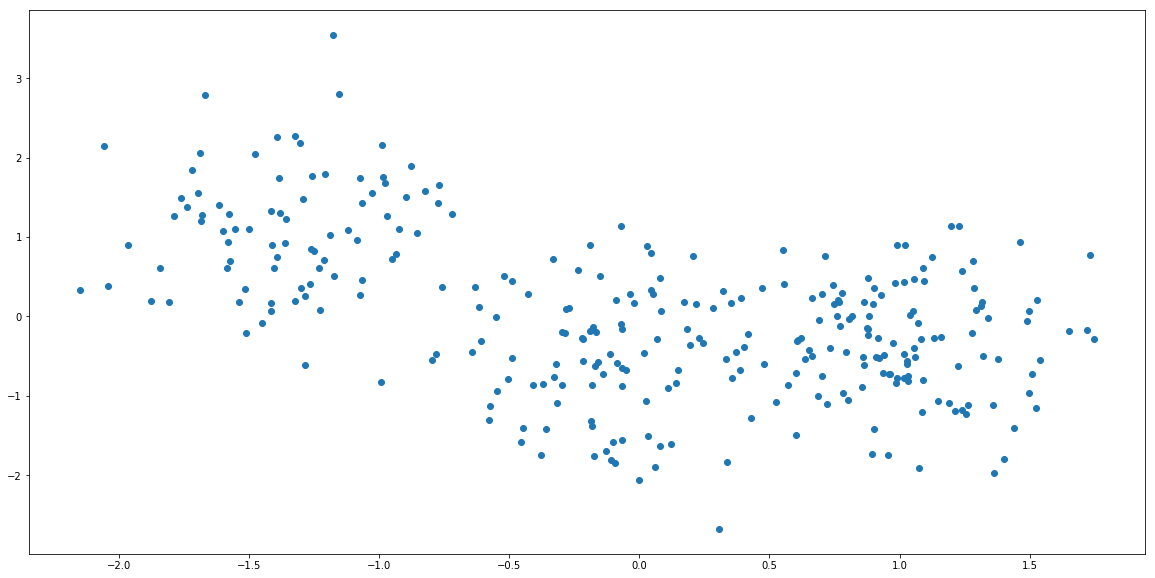

In [7]:
X_ = X.copy()
std = StandardScaler()
X_std = std.fit_transform(X_)

plt.figure(figsize=(20,10))
plt.plot(X_[:,0], X_[:,1], 'o')
plt.show()

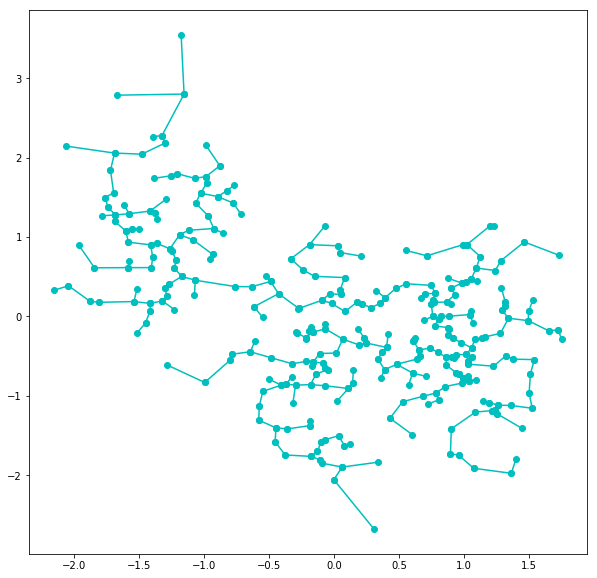

In [8]:
# initialise a EMST class instance
emst = EMST(X_std)

# 1. get the adjacency matrix from the data array
emst.getAdjMatrix()

# 2. then get the Euclidean minimum spanning tree
emst.getEMST()

# 3. convert the tree in dictionnary format
emst._transformTree()
nodes_dict = emst.mst_node_neighb

# 4. (optional) plot the minimum spanning tree
plotTree(X_,emst.mst_pair_weight)

In [9]:
#y = np.random.binomial(n=1, p=[betas[i] for i in np.random.choice([0,1,2], size=590)])
y = pd.read_csv('y_new.csv', sep=",", header=None)
#y = y.drop(0, axis=1)
#y = np.asarray(y['x'].values)
y = y.fillna(0.0)
#y = y.drop(0, axis=1).values
y = np.asarray(y.iloc[:,1].values)
y

array([ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0

In [10]:
class EMSTSegmentation():
    """Performs fused adaptive Ridge over a set of points.

    Parameters
    ----------
    y : array-like, shape=[n_samples,]
    The data used as an input for the clustering process.

    W : array-like, shape=[n_samples, n_samples]
    The sparse matrix of weights related to edges in the EMST.
    This input is only used if warm_start is set as True.

    nodes_dict : dictionnary
    {k, v} as {node, [connected nodes]}.

    lmbda : float
    The Ridge penalization factor.

    delta : float
    The float used for reference to assess if two different clustering centers are similar.

    max_iter : int
    The maximum number of iterations if convergence is not reached before.

    tol : float
    The convergence criterion.

    print_convergence : boolean
    If True, prints additionnal information for each iteration.

    print_specific_computing_times : boolean
    If True, prints the computing times for W, A and mu, for each iteration, in ms.

    warm_start : boolean
    If True, when performing grid-search over a set of lambdas, uses the latest W as 
    a starting point for the following lambda.

    Attributes
    ----------        
    cluster_centers_ : array_like, shape=[K, n_dim] where K is the number of clusters.
    Coordinates of centroids.

    labels_: array-like, shape=[n_samples, 1]
    Labels of each point.

    """        
    def __init__(self, y, W, nodes_dict, lmbda=1.0, delta=1e-5,
                max_iter=500, max_iter_NR=20, tol=1e-5, print_convergence=False,
                print_clustering_summary=False, print_specific_computing_times=False,
                warm_start=True):
        self.lmbda = lmbda
        self.delta = delta
        self.max_iter = max_iter
        self.max_iter_NR = max_iter_NR
        self.tol = tol
        self.thresh = 0.99
        self.print_convergence = print_convergence
        self.print_clustering_summary = print_clustering_summary
        self.print_specific_computing_times = print_specific_computing_times
        self.beta_history = []
        self.clusters_centers_ = []
        self.groups = {}
        self.valist = []
        self.n_samples = y.shape[0]
        self.labels_ = np.asarray([None] * self.n_samples)
        self.A = np.zeros((self.n_samples, self.n_samples))
        self.W = np.ones((self.n_samples, self.n_samples))
        self.sel = np.ones((self.n_samples, self.n_samples))
        self.labels_history = {}
        self.clusters_centers_history = {}
        
        self.y2 = y
        self.y2 = self.y2.astype(float)
        self.y2[np.where(self.y2==1.0)] = 0.9
        self.y2[np.where(self.y2==0.0)] = 0.1
        self.beta = np.log(self.y2 / (1-self.y2))
        self.penLLold = -np.inf
        self.penSum = 0
        self.b = np.zeros((self.n_samples))
        
        if warm_start==True:
            self.W = W
     
    def update_beta(self, y):
        """Solves the sparse linear system X=Amu.

        Parameters
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 

        """
        if self.print_specific_computing_times==True:
            print("Updating beta...")
        time1 = time.time()
        for i in range(self.max_iter_NR):
            if i==self.max_iter_NR-1:
                print("NR did not reach convergence. Returning last beta.")
                break;
            elif i<self.max_iter_NR-1:
                self.tau = 1 / (1+np.exp(-self.beta))
                self.update_A_and_b(y)
                self.beta += scipy.sparse.linalg.spsolve(self.A, self.b)
                penLL = np.sum(y * self.beta - np.log(1+np.exp(self.beta))) - (self.lmbda/2) * self.penSum
                
        time2 = time.time()
        if self.print_specific_computing_times==True:
            print("Mu updated. Time elapsed : " + str((time2-time1)*1000.0) + "ms.")
        
    def update_W(self):
        """Updates W and sel.
        
        """
        if self.print_specific_computing_times==True:
            print("Updating W...")
        time1 = time.time()
        # Update the weight matrix :
        for i in list(nodes_dict.keys()):
            for j in list(nodes_dict.get(i)):
                self.W[i,j] = 1/((np.linalg.norm(self.beta[i]-self.beta[j]))**2 + self.delta**2)  
                self.sel[i,j] = self.W[i,j] * (np.linalg.norm(self.beta[i]-self.beta[j]))**2
        time2 = time.time()
        if self.print_specific_computing_times==True:
            print("W updated. Time elapsed : " + str((time2-time1)*1000.0) + "ms.") 
            
    def update_A_and_b(self, y):
        """Updates A and b.
        
        """
        if self.print_specific_computing_times==True:
            print("Updating A...")
        time1 = time.time()
        self.A = np.zeros((self.n_samples, self.n_samples))
        self.penSum = 0
        for node in list(nodes_dict.keys()):
            sum_W = 0
            sum_W_beta = 0
            for linked_node in list(nodes_dict.get(node)):
                sum_W += self.W[node, linked_node]
                sum_W_beta += self.W[node, linked_node] * (self.beta[node] - self.beta[linked_node])
                self.penSum += self.W[node, linked_node] * (self.beta[node] - self.beta[linked_node])
                self.A[node, linked_node] += -self.lmbda * self.W[node, linked_node]

            self.A[node, node] += self.lmbda * sum_W + self.tau[node]*(1-self.tau[node])
            self.b[node] = y[node] - self.tau[node] - self.lmbda * sum_W_beta 
        time2 = time.time()
        if self.print_specific_computing_times==True:
            print("A updated. Time elapsed : " + str((time2-time1)*1000.0) + "ms.")
    
    def optim_update(self, y):
        """Updates W and mu, then W.
        Parameter
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 

        """
        # Update beta :
        self.update_beta(y)
        # Update weights : 
        self.update_W()
    
    def fit(self, y):
        """Iterates until tolerance criteria is reached or max_iter is exceeded.
        Once convergence is reached, plots the data with cluster colors and a convergence plot.
        Parameter
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 

        """
        if self.print_convergence==True:
            print("Iterating...")
        for i in range(self.max_iter):
            if i==self.max_iter-1:
                print("Did not reach convergence. Returning last Beta.")
                break;
            elif i<self.max_iter-1:
                if i==0:
                    if self.print_convergence==True:
                        print("Iteration " + str(i)) 
                    mu_old = self.beta.copy()
                    self.optim_update(y)
                    self.beta_history.append(np.max((np.abs(self.beta-mu_old)) / (np.abs(mu_old))))
                    if self.print_convergence==True:
                        print(np.max((np.abs(self.beta-mu_old)) / (np.abs(mu_old))))
                elif i>0:
                    if self.print_convergence==True:
                        print("Iteration " + str(i))
                    if np.max((np.abs(self.beta-mu_old)) / (np.abs(mu_old))) < self.tol:
                        print("Convergence reached in " + str(i) +" iterations.")
                        break;
                    else:
                        mu_old = self.beta.copy()
                        self.optim_update(y)
                        self.beta_history.append(np.max((np.abs(self.beta-mu_old)) / (np.abs(mu_old))))
                        if self.print_convergence==True:
                            print(np.max((np.abs(self.beta-mu_old)) / (np.abs(mu_old))))
                            
        # Dict of groups as in key is a node and corresponding value is a list of nodes fused with it.
        # Two nodes are linked by an edge if their relative betas are highly similar. 
        # If the difference between their respective betas exceeds a threshold, their edge is cut.
        # When convergence is reached, the nodes that are still linked by edges belong to the same cluster.
        for i in range(self.n_samples):

            self.groups[i] = np.where(self.sel[i,:]<self.thresh)

        # Merges the groups of nodes with common elements :
        for key, value in (self.groups.items()):
            temp_list = list(value[0])
            temp_list.append(key)
            self.valist.append(tuple(temp_list))
        self.valist = self.merge_tuples(list(set(self.valist)))
        print(str(len(self.valist)) + " clusters found.")
        print(self.valist)

        # Computes labels :
        for i, cluster in enumerate(self.valist):
            self.clusters_centers_.append(self.beta[cluster[0]])
            for value in cluster:
                self.labels_[value] = i 
                
        self.labels_history[self.lmbda] = self.labels_
        self.clusters_centers_history[self.lmbda] = self.clusters_centers_

        return self
                            
    def plot_history(self):
        """Plots the convergence curve.
        
        """
        plt.figure(figsize=(16,10))
        plt.plot(self.beta_history, 'r')
        plt.title('Convergence history')
        plt.xlabel('Iteration')
        plt.ylabel('max(|mu-mu_old|/|mu_old|)')
        plt.grid()
        plt.show()
        
    def plot_clusters(self, X):
        """Regroups and plots the clusters.
        
        Parameters
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 
        
        """   
        toplot = X.copy()
        if X.shape[1]>2:
            std = StandardScaler()
            X_std = std.fit_transform(X)
            seed = 2019
            tsne = TSNE(perplexity=30, learning_rate=500, random_state=seed)
            X_tsne = tsne.fit_transform(X_std)
            toplot = X_tsne
        
        # Defines the bank of colors used later on :
        colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
        colorz = list(colors.keys())
            
        # Plots the different samples with a color respective to their cluster :
        plt.figure(figsize=(16,10))
        for i, cluster in enumerate(self.valist):
            color = np.random.choice(list(mcolors.CSS4_COLORS.keys()))
            if self.print_clustering_summary==True:
                print("Cluster " + str(i))
                print("-------")
                print(cluster)
            for value in cluster:
                plt.plot(toplot[value,0], toplot[value,1], 'o', c=color, label='Cluster ' + str(i))

        handles, labels = plt.gca().get_legend_handles_labels()
        labels, ids = np.unique(labels, return_index=True)
        handles = [handles[i] for i in ids]
        plt.legend(handles, labels, loc='best')
        plt.title('Clustering results in proximity space')
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        plt.grid()
        plt.show()   
        
    def merge_tuples(self, tuple_list):        
        """Fuses the lists of common nodes.
        
        Parameters
        ----------
        tuple_list : list
        The list of tuples that we want to get merged. 
        
        """
        # Converts the input list as a set of sets
        iset = set([frozenset(s) for s in tuple_list])  
        result = []
        while(iset):                  
            nset = set(iset.pop())      
            check = len(iset)           
            while check:                
                check = False
                for s in iset.copy():       
                    if nset.intersection(s):  
                        check = True           
                        iset.remove(s)          
                        nset.update(s)          
            result.append(tuple(nset)) 

        return result
    
def plot_clustering_results(X, labels):
    
    # Defines the bank of colors used later on :
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    colorz = list(colors.keys())
    colorz2 = colorz.copy()
    
    diff = len(list(Counter(labels).keys()))-len(colorz)
    
    if diff>0:
        for k in range(diff):
            colorz.append(np.random.choice(colorz))
    
    toplot = X.copy()
    toplot0 = 'X_0'
    toplot1 = 'X_1'
    if X.shape[1]>2:
        std = StandardScaler()
        X_std = std.fit_transform(X)
        seed = 2019
        tsne = TSNE(perplexity=30, learning_rate=500, random_state=seed)
        X_tsne = tsne.fit_transform(X_std)
        toplot = X_tsne
        toplot0 = 'X_tsne_0'
        toplot1 = 'X_tsne_1'
    
    fig, ax = plt.subplots(figsize=(16,10))
    scatter = ax.scatter(toplot[:,0], toplot[:,1], c=[colorz[i] for i in labels]) #cmap=[colorz[i] for i in labels])
    plt.xlabel(toplot0)
    plt.ylabel(toplot1)
    plt.title('Clustering results in proximity space - ' + str(len(list(Counter(labels).keys()))) + ' clusters found.')
    plt.grid()
    plt.show()

In [30]:
lambdas = np.logspace(-4, 4, 40)
lambdas = np.logspace(-1, 3, 30)
silhouette = {}
bic = {}
noenh_bic = {}
n_clusters = {}
betas_1 = np.asarray([None] * y.shape[0])
taus_1 = np.asarray([None] * y.shape[0])
tol = 1e-4
warm_start = True
print_convergence = True
plot_history = False
labels_history = {}
clusters_centers_history = {}
labels_by_best_BIC = []
clusters_centers_by_best_BIC = []

for i, lmbda in enumerate(lambdas):
    print("Lambda=" +str(lmbda))
    if i==0:
        e_ = EMSTSegmentation(y, None, nodes_dict, lmbda=lmbda, tol=tol, print_convergence=print_convergence, print_clustering_summary=False, warm_start=False)
    elif i>0:
        e_ = EMSTSegmentation(y, previous_weights, nodes_dict, lmbda=lmbda, tol=tol, print_convergence=print_convergence, print_clustering_summary=False, warm_start=warm_start)    
    e_.fit(y)
    if plot_history==True:
        e_.plot_history()
    previous_weights = e_.W.copy()
    previous_mus = e_.beta.copy()
    betas_1 = np.vstack((betas_1, previous_mus))
    taus_1 = np.vstack((taus_1, (1 / (1+np.exp(-previous_mus)))))
    #current_BIC = compute_BIC(y, e_.clusters_centers_, e_.sigma, e_.emission_probas)
    #bic[lmbda] = current_BIC
    #noenh_bic[lmbda] = compute_BIC(y, e_.clusters_centers_, e_.sigma, e_.emission_probas, enhanced=False)
    n_clusters[lmbda] = len(e_.clusters_centers_)
    labels_history[lmbda] = e_.labels_
    clusters_centers_history[lmbda] = e_.clusters_centers_
    #min_BIC = np.min(np.asarray(list(bic.values())))
    #if current_BIC<=min_BIC:
    #    labels_by_best_BIC = e_.labels_
    #    clusters_centers_by_best_BIC = e_.clusters_centers_

Lambda=0.1
Iterating...
Iteration 0
NR did not reach convergence. Returning last beta.
2.32122437948
Iteration 1
NR did not reach convergence. Returning last beta.
10.9437267751
Iteration 2


/Users/cluclu/anaconda/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


NR did not reach convergence. Returning last beta.
8.61392215872
Iteration 3
NR did not reach convergence. Returning last beta.
0.847149611359
Iteration 4
NR did not reach convergence. Returning last beta.
0.275506477507
Iteration 5
NR did not reach convergence. Returning last beta.
0.103748589561
Iteration 6
NR did not reach convergence. Returning last beta.
0.043577112443
Iteration 7
NR did not reach convergence. Returning last beta.
0.0189888496488
Iteration 8
NR did not reach convergence. Returning last beta.
0.0082761874809
Iteration 9
NR did not reach convergence. Returning last beta.
0.00360770631728
Iteration 10
NR did not reach convergence. Returning last beta.
0.00157210563761
Iteration 11
NR did not reach convergence. Returning last beta.
0.000684558635262
Iteration 12
NR did not reach convergence. Returning last beta.
0.000297800546717
Iteration 13
NR did not reach convergence. Returning last beta.
0.000129417982248
Iteration 14
NR did not reach convergence. Returning last 

NR did not reach convergence. Returning last beta.
0.0297078565966
Iteration 5
NR did not reach convergence. Returning last beta.
0.0220431365302
Iteration 6
NR did not reach convergence. Returning last beta.
0.0165214778569
Iteration 7
NR did not reach convergence. Returning last beta.
0.0124761619327
Iteration 8
NR did not reach convergence. Returning last beta.
0.00947352166066
Iteration 9
NR did not reach convergence. Returning last beta.
0.00722250673614
Iteration 10
NR did not reach convergence. Returning last beta.
0.00552228784944
Iteration 11
NR did not reach convergence. Returning last beta.
0.0042309434143
Iteration 12
NR did not reach convergence. Returning last beta.
0.00324615849377
Iteration 13
NR did not reach convergence. Returning last beta.
0.00249296200464
Iteration 14
NR did not reach convergence. Returning last beta.
0.00191570383927
Iteration 15
NR did not reach convergence. Returning last beta.
0.00147265798105
Iteration 16
NR did not reach convergence. Returnin

NR did not reach convergence. Returning last beta.
0.00349998357646
Iteration 62
NR did not reach convergence. Returning last beta.
0.00236791370652
Iteration 63
NR did not reach convergence. Returning last beta.
0.00164448974914
Iteration 64
NR did not reach convergence. Returning last beta.
0.00115468218936
Iteration 65
NR did not reach convergence. Returning last beta.
0.000814804429059
Iteration 66
NR did not reach convergence. Returning last beta.
0.000576267550092
Iteration 67
NR did not reach convergence. Returning last beta.
0.000407952678751
Iteration 68
NR did not reach convergence. Returning last beta.
0.000288889584544
Iteration 69
NR did not reach convergence. Returning last beta.
0.00020457437963
Iteration 70
NR did not reach convergence. Returning last beta.
0.00014484331644
Iteration 71
NR did not reach convergence. Returning last beta.
0.0001025274526
Iteration 72
NR did not reach convergence. Returning last beta.
7.25541152101e-05
Iteration 73
Convergence reached in 7

NR did not reach convergence. Returning last beta.
0.0226808628634
Iteration 18
NR did not reach convergence. Returning last beta.
0.0209323026545
Iteration 19
NR did not reach convergence. Returning last beta.
0.0193592231759
Iteration 20
NR did not reach convergence. Returning last beta.
0.0179472051215
Iteration 21
NR did not reach convergence. Returning last beta.
0.0166808304092
Iteration 22
NR did not reach convergence. Returning last beta.
0.0155443107435
Iteration 23
NR did not reach convergence. Returning last beta.
0.0145224793147
Iteration 24
NR did not reach convergence. Returning last beta.
0.0136013828839
Iteration 25
NR did not reach convergence. Returning last beta.
0.0127685484791
Iteration 26
NR did not reach convergence. Returning last beta.
0.0120130330193
Iteration 27
NR did not reach convergence. Returning last beta.
0.0113253469145
Iteration 28
NR did not reach convergence. Returning last beta.
0.0106973156842
Iteration 29
NR did not reach convergence. Returning 

NR did not reach convergence. Returning last beta.
0.0561701994549
Iteration 120
NR did not reach convergence. Returning last beta.
0.0703454967703
Iteration 121
NR did not reach convergence. Returning last beta.
0.0906879272076
Iteration 122
NR did not reach convergence. Returning last beta.
0.121376666687
Iteration 123
NR did not reach convergence. Returning last beta.
0.170926418128
Iteration 124
NR did not reach convergence. Returning last beta.
0.259331451061
Iteration 125
NR did not reach convergence. Returning last beta.
0.446124765413
Iteration 126
NR did not reach convergence. Returning last beta.
1.02556405455
Iteration 127
NR did not reach convergence. Returning last beta.
49.0207585116
Iteration 128
NR did not reach convergence. Returning last beta.
1.03054111861
Iteration 129
NR did not reach convergence. Returning last beta.
0.355645365444
Iteration 130
NR did not reach convergence. Returning last beta.
0.0743225278035
Iteration 131
NR did not reach convergence. Returning

NR did not reach convergence. Returning last beta.
0.000168840276074
Iteration 222
NR did not reach convergence. Returning last beta.
0.000166681241948
Iteration 223
NR did not reach convergence. Returning last beta.
0.000164553539533
Iteration 224
NR did not reach convergence. Returning last beta.
0.000162456626338
Iteration 225
NR did not reach convergence. Returning last beta.
0.00016038997134
Iteration 226
NR did not reach convergence. Returning last beta.
0.00015835305466
Iteration 227
NR did not reach convergence. Returning last beta.
0.00015634536732
Iteration 228
NR did not reach convergence. Returning last beta.
0.000154366410933
Iteration 229
NR did not reach convergence. Returning last beta.
0.000152415697462
Iteration 230
NR did not reach convergence. Returning last beta.
0.000150492748955
Iteration 231
NR did not reach convergence. Returning last beta.
0.000148597097291
Iteration 232
NR did not reach convergence. Returning last beta.
0.000146728283932
Iteration 233
NR did 

NR did not reach convergence. Returning last beta.
0.00751947074445
Iteration 42
NR did not reach convergence. Returning last beta.
0.00729821844491
Iteration 43
NR did not reach convergence. Returning last beta.
0.00708664282325
Iteration 44
NR did not reach convergence. Returning last beta.
0.00688417662837
Iteration 45
NR did not reach convergence. Returning last beta.
0.00669029436419
Iteration 46
NR did not reach convergence. Returning last beta.
0.00650450857749
Iteration 47
NR did not reach convergence. Returning last beta.
0.00632636653674
Iteration 48
NR did not reach convergence. Returning last beta.
0.00615544725298
Iteration 49
NR did not reach convergence. Returning last beta.
0.00599135880149
Iteration 50
NR did not reach convergence. Returning last beta.
0.00583373590869
Iteration 51
NR did not reach convergence. Returning last beta.
0.00568223777384
Iteration 52
NR did not reach convergence. Returning last beta.
0.005536546099
Iteration 53
NR did not reach convergence. 

NR did not reach convergence. Returning last beta.
0.00111045713259
Iteration 145
NR did not reach convergence. Returning last beta.
0.00109646684068
Iteration 146
NR did not reach convergence. Returning last beta.
0.00108271760897
Iteration 147
NR did not reach convergence. Returning last beta.
0.00106920395891
Iteration 148
NR did not reach convergence. Returning last beta.
0.00105592056746
Iteration 149
NR did not reach convergence. Returning last beta.
0.00104286226182
Iteration 150
NR did not reach convergence. Returning last beta.
0.00103002401435
Iteration 151
NR did not reach convergence. Returning last beta.
0.00101740093765
Iteration 152
NR did not reach convergence. Returning last beta.
0.00100498827994
Iteration 153
NR did not reach convergence. Returning last beta.
0.000992781420489
Iteration 154
NR did not reach convergence. Returning last beta.
0.000980775865324
Iteration 155
NR did not reach convergence. Returning last beta.
0.000968967243042
Iteration 156
NR did not re

NR did not reach convergence. Returning last beta.
0.000388687858168
Iteration 244
NR did not reach convergence. Returning last beta.
0.000385160863915
Iteration 245
NR did not reach convergence. Returning last beta.
0.000381673780058
Iteration 246
NR did not reach convergence. Returning last beta.
0.000378226029933
Iteration 247
NR did not reach convergence. Returning last beta.
0.000374817047278
Iteration 248
NR did not reach convergence. Returning last beta.
0.000371446275989
Iteration 249
NR did not reach convergence. Returning last beta.
0.000368113169916
Iteration 250
NR did not reach convergence. Returning last beta.
0.000364817192655
Iteration 251
NR did not reach convergence. Returning last beta.
0.000361557817316
Iteration 252
NR did not reach convergence. Returning last beta.
0.000358334526334
Iteration 253
NR did not reach convergence. Returning last beta.
0.00035514681128
Iteration 254
NR did not reach convergence. Returning last beta.
0.000351994172643
Iteration 255
NR di

NR did not reach convergence. Returning last beta.
0.00017029637931
Iteration 343
NR did not reach convergence. Returning last beta.
0.0001689848129
Iteration 344
NR did not reach convergence. Returning last beta.
0.000167684864525
Iteration 345
NR did not reach convergence. Returning last beta.
0.000166396409755
Iteration 346
NR did not reach convergence. Returning last beta.
0.000165119325814
Iteration 347
NR did not reach convergence. Returning last beta.
0.000163853491522
Iteration 348
NR did not reach convergence. Returning last beta.
0.000162598787293
Iteration 349
NR did not reach convergence. Returning last beta.
0.000161355095107
Iteration 350
NR did not reach convergence. Returning last beta.
0.000160122298467
Iteration 351
NR did not reach convergence. Returning last beta.
0.000158900282403
Iteration 352
NR did not reach convergence. Returning last beta.
0.000157688933419
Iteration 353
NR did not reach convergence. Returning last beta.
0.000156488139502
Iteration 354
NR did 

NR did not reach convergence. Returning last beta.
0.293594020807
Iteration 9
NR did not reach convergence. Returning last beta.
0.268552322334
Iteration 10
NR did not reach convergence. Returning last beta.
0.178637761209
Iteration 11
NR did not reach convergence. Returning last beta.
0.201390770477
Iteration 12
NR did not reach convergence. Returning last beta.
0.237007777736
Iteration 13
NR did not reach convergence. Returning last beta.
0.29891303837
Iteration 14
NR did not reach convergence. Returning last beta.
0.41169737429
Iteration 15
NR did not reach convergence. Returning last beta.
0.679874050769
Iteration 16
NR did not reach convergence. Returning last beta.
2.09924713862
Iteration 17
NR did not reach convergence. Returning last beta.
1.91579915085
Iteration 18
NR did not reach convergence. Returning last beta.
0.667541198177
Iteration 19
NR did not reach convergence. Returning last beta.
0.411732328482
Iteration 20
NR did not reach convergence. Returning last beta.
0.3037

NR did not reach convergence. Returning last beta.
0.000105573739873
Iteration 48
NR did not reach convergence. Returning last beta.
8.23797460662e-05
Iteration 49
Convergence reached in 49 iterations.
9 clusters found.
[(256, 258, 4, 5, 6, 264, 265, 266, 267, 268, 13, 14, 271, 272, 276, 24, 282, 283, 28, 29, 285, 32, 33, 34, 35, 292, 38, 295, 296, 299, 44, 45, 46, 47, 48, 50, 54, 55, 56, 62, 72, 73, 74, 76, 78, 83, 90, 93, 96, 99, 102, 105, 109, 111, 112, 121, 122, 124, 127, 130, 132, 134, 135, 136, 137, 138, 140, 142, 145, 146, 149, 150, 155, 156, 157, 160, 162, 164, 169, 170, 171, 175, 176, 181, 185, 190, 193, 200, 207, 214, 221, 228, 231, 234, 235, 236, 237, 239, 241, 247, 249, 251, 254), (128, 65, 191, 3, 2, 69, 0, 199, 7, 17, 147, 22, 281, 218, 27, 161, 291, 166, 104, 233, 106, 242, 51, 248, 252, 189, 63), (129, 1, 260, 262, 11, 269, 20, 148, 278, 23, 151, 153, 284, 287, 290, 163, 36, 165, 294, 167, 37, 42, 43, 172, 182, 57, 58, 59, 188, 64, 68, 197, 70, 196, 71, 198, 204, 205, 2

NR did not reach convergence. Returning last beta.
0.295126903533
Iteration 3
NR did not reach convergence. Returning last beta.
0.259094266526
Iteration 4
NR did not reach convergence. Returning last beta.
0.175485353566
Iteration 5
NR did not reach convergence. Returning last beta.
0.0632408095996
Iteration 6
NR did not reach convergence. Returning last beta.
0.0344856161673
Iteration 7
NR did not reach convergence. Returning last beta.
0.0326211796491
Iteration 8
NR did not reach convergence. Returning last beta.
0.0331996466051
Iteration 9
NR did not reach convergence. Returning last beta.
0.034101873359
Iteration 10
NR did not reach convergence. Returning last beta.
0.0352357725442
Iteration 11
NR did not reach convergence. Returning last beta.
0.03654855
Iteration 12
NR did not reach convergence. Returning last beta.
0.0380323520567
Iteration 13
NR did not reach convergence. Returning last beta.
0.0397039949392
Iteration 14
NR did not reach convergence. Returning last beta.
0.041

NR did not reach convergence. Returning last beta.
2.05164425215
Iteration 1
NR did not reach convergence. Returning last beta.
0.0902829212038
Iteration 2
NR did not reach convergence. Returning last beta.
0.0587503337806
Iteration 3
NR did not reach convergence. Returning last beta.
0.0385518441082
Iteration 4
NR did not reach convergence. Returning last beta.
0.0254943033084
Iteration 5
NR did not reach convergence. Returning last beta.
0.0169576729358
Iteration 6
NR did not reach convergence. Returning last beta.
0.0113259213848
Iteration 7
NR did not reach convergence. Returning last beta.
0.00758596176877
Iteration 8
NR did not reach convergence. Returning last beta.
0.00509079736178
Iteration 9
NR did not reach convergence. Returning last beta.
0.00342080933578
Iteration 10
NR did not reach convergence. Returning last beta.
0.00230067710233
Iteration 11
NR did not reach convergence. Returning last beta.
0.00154825111249
Iteration 12
NR did not reach convergence. Returning last b

NR did not reach convergence. Returning last beta.
0.0753097572893
Iteration 2
NR did not reach convergence. Returning last beta.
0.0495833460845
Iteration 3
NR did not reach convergence. Returning last beta.
0.0337238645058
Iteration 4
NR did not reach convergence. Returning last beta.
0.0234214040921
Iteration 5
NR did not reach convergence. Returning last beta.
0.0164952857315
Iteration 6
NR did not reach convergence. Returning last beta.
0.0117293896835
Iteration 7
NR did not reach convergence. Returning last beta.
0.00839659694331
Iteration 8
NR did not reach convergence. Returning last beta.
0.00603935012889
Iteration 9
NR did not reach convergence. Returning last beta.
0.00435857991703
Iteration 10
NR did not reach convergence. Returning last beta.
0.00315320712025
Iteration 11
NR did not reach convergence. Returning last beta.
0.00228516768719
Iteration 12
NR did not reach convergence. Returning last beta.
0.00165817834905
Iteration 13
NR did not reach convergence. Returning la

NR did not reach convergence. Returning last beta.
2.03135268744e-16
Iteration 2
Convergence reached in 2 iterations.
1 clusters found.
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 19

In [31]:
nodes_dict

{0: array([17]),
 1: array([ 11, 115, 167]),
 2: array([ 61, 242]),
 3: array([ 69, 281]),
 4: array([ 33,  90, 214]),
 5: array([207, 237]),
 6: array([78, 96]),
 7: array([106, 274]),
 8: array([ 60, 110]),
 9: array([ 85, 126, 194]),
 10: array([26, 84]),
 11: array([  1, 278]),
 12: array([ 26, 100, 187]),
 13: array([ 46, 145]),
 14: array([131, 145]),
 15: array([183, 211, 289]),
 16: array([60]),
 17: array([  0,  65, 106]),
 18: array([ 88, 143, 212]),
 19: array([209, 213]),
 20: array([269, 287]),
 21: array([ 31, 119, 277]),
 22: array([218]),
 23: array([37, 71]),
 24: array([ 48, 190]),
 25: array([277]),
 26: array([10, 12]),
 27: array([104, 248]),
 28: array([282]),
 29: array([ 99, 138, 170]),
 30: array([118, 125, 174, 270]),
 31: array([21]),
 32: array([122, 127, 299]),
 33: array([  4, 185]),
 34: array([111, 292]),
 35: array([239, 276]),
 36: array([80]),
 37: array([ 23, 117, 250]),
 38: array([214, 249]),
 39: array([ 88, 100]),
 40: array([168, 232]),
 41: arr

In [32]:
n_clusters

{0.10000000000000001: 56,
 0.1373823795883263: 56,
 0.18873918221350972: 56,
 0.25929437974046671: 56,
 0.35622478902624422: 41,
 0.4893900918477494: 34,
 0.6723357536499337: 31,
 0.92367085718738606: 17,
 1.2689610031679222: 9,
 1.7433288221999881: 9,
 2.3950266199874859: 7,
 3.2903445623126677: 4,
 4.5203536563602427: 4,
 6.2101694189156165: 4,
 8.5316785241728059: 4,
 11.721022975334806: 2,
 16.102620275609393: 2,
 22.122162910704478: 2,
 30.391953823131981: 1,
 41.753189365604001: 1,
 57.361525104486816: 1,
 78.804628156699124: 1,
 108.2636733874054: 1,
 148.73521072935117: 1,
 204.33597178569417: 1,
 280.72162039411756: 1,
 385.66204211634721: 1,
 529.83169062837078: 1,
 727.8953843983146: 1,
 1000.0: 1}

Clustering results according to eBIC :


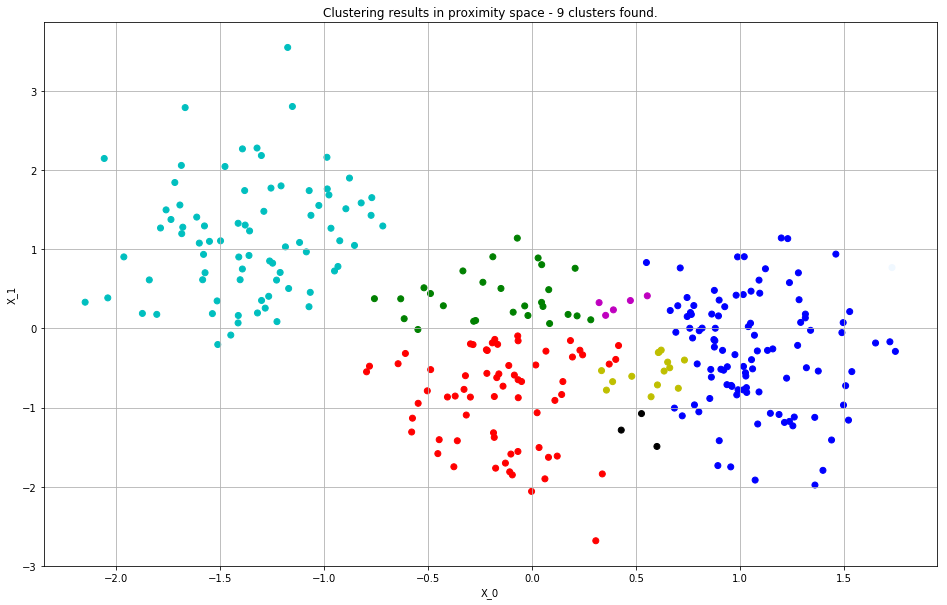

In [33]:
print("Clustering results according to eBIC :")
lbda = 1.2689610031679222
plot_clustering_results(X_, labels_history.get(lbda))

In [34]:
betas_1 = betas_1.T
betas_1 = betas_1[:,1:]

taus_1 = taus_1.T
taus_1 = taus_1[:,1:]

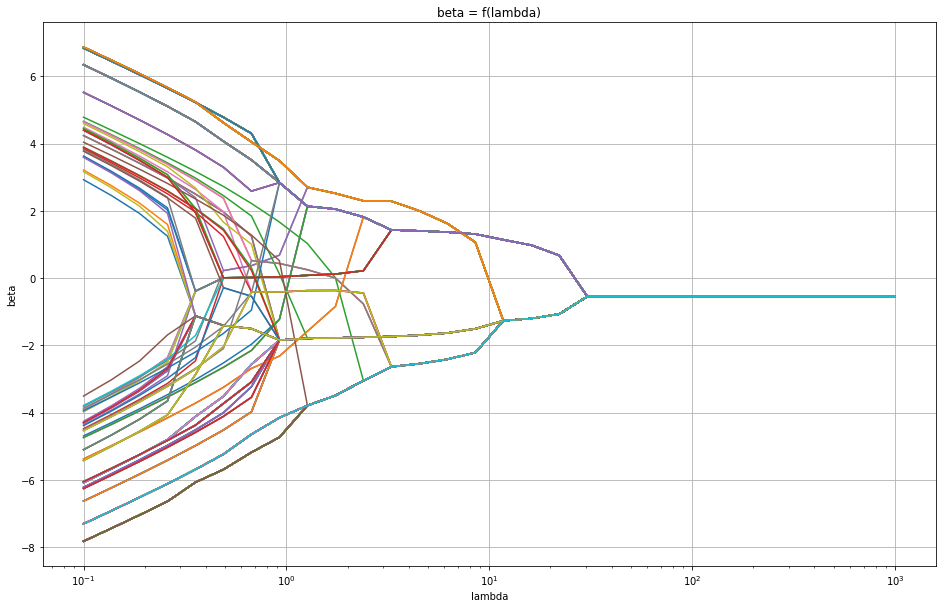

In [35]:
plt.figure(figsize=(16,10))
for k in range(betas_1.shape[0]):
    plt.plot(lambdas, betas_1[k])
plt.title('beta = f(lambda)')
plt.grid()
plt.xlabel('lambda')
plt.ylabel('beta')
plt.xscale('log')
#plt.axvline(lambdas[np.argmin(np.asarray(list(bic.values())))], ls='--',color='black')
plt.show()

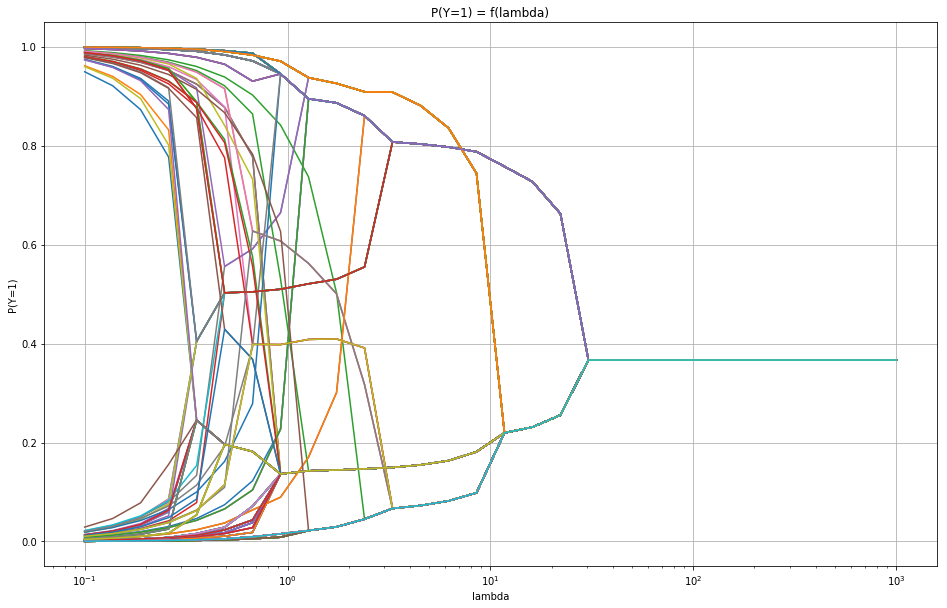

In [37]:
plt.figure(figsize=(16,10))
for k in range(taus_1.shape[0]):
    plt.plot(lambdas, taus_1[k])
plt.title('P(Y=1) = f(lambda)')
plt.grid()
plt.xlabel('lambda')
plt.ylabel('P(Y=1)')
plt.xscale('log')
#plt.axvline(lambdas[np.argmin(np.asarray(list(bic.values())))], ls='--',color='black')
plt.show()